In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO007901564,53,2018-11-02 15:55:04.957,246,HIRU PHARMACY,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,203,Enervon-C Film Cap 30's,2.0,657.89,750.00,0.0,0.0,1315.78,2018,November,11,2,6,Friday,15
1,CSO007901564,53,2018-11-02 15:55:04.957,246,HIRU PHARMACY,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,335,Enervon Hp Choco. 400gm,2.0,1667.00,1850.00,0.0,0.0,3334.00,2018,November,11,2,6,Friday,15
2,CSO011701384,54,2018-11-02 15:55:30.927,354,PAVITHRA PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,94,Thermoseal R.A. 50gm,6.0,256.20,292.00,0.0,0.0,1537.20,2018,November,11,2,6,Friday,15
3,BO0104000041,0,2018-11-02 17:02:48.327,2685,Jeewaka Pharmacy,Southern Province,Hambantota,Hambantota,104,Praneeth Waruna,14,Unichemist Distributor,3,Futop Cream 5gm,10.0,308.55,351.75,0.0,0.0,3085.50,2018,November,11,2,6,Friday,17
4,BO0104000041,0,2018-11-02 17:02:48.327,2685,Jeewaka Pharmacy,Southern Province,Hambantota,Hambantota,104,Praneeth Waruna,14,Unichemist Distributor,3,Futop Cream 5gm,0.0,308.55,351.75,1.0,1.0,0.00,2018,November,11,2,6,Friday,17


In [7]:
Sec_invoice_All = invoice_All

In [8]:
Sec_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO007901564,53,2018-11-02 15:55:04.957,246,HIRU PHARMACY,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,203,Enervon-C Film Cap 30's,2.0,657.89,750.00,0.0,0.0,1315.78,2018,November,11,2,6,Friday,15
1,CSO007901564,53,2018-11-02 15:55:04.957,246,HIRU PHARMACY,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,335,Enervon Hp Choco. 400gm,2.0,1667.00,1850.00,0.0,0.0,3334.00,2018,November,11,2,6,Friday,15
2,CSO011701384,54,2018-11-02 15:55:30.927,354,PAVITHRA PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,94,Thermoseal R.A. 50gm,6.0,256.20,292.00,0.0,0.0,1537.20,2018,November,11,2,6,Friday,15
3,BO0104000041,0,2018-11-02 17:02:48.327,2685,Jeewaka Pharmacy,Southern Province,Hambantota,Hambantota,104,Praneeth Waruna,14,Unichemist Distributor,3,Futop Cream 5gm,10.0,308.55,351.75,0.0,0.0,3085.50,2018,November,11,2,6,Friday,17
4,BO0104000041,0,2018-11-02 17:02:48.327,2685,Jeewaka Pharmacy,Southern Province,Hambantota,Hambantota,104,Praneeth Waruna,14,Unichemist Distributor,3,Futop Cream 5gm,0.0,308.55,351.75,1.0,1.0,0.00,2018,November,11,2,6,Friday,17


In [9]:
 #get date from date time
Sec_invoice_All['just_date'] = Sec_invoice_All['Date'].dt.date

In [10]:
Sec_inv_grp = Sec_invoice_All.groupby("just_date").agg({'GrossValue':'sum'}).reset_index()

In [11]:
Sec_inv_grp

,just_date,GrossValue
0,2018-11-01,1053634.82
1,2018-11-02,2381350.80
2,2018-11-03,2481154.42
3,2018-11-04,216434.55
4,2018-11-05,5156889.73
...,...,...
475,2020-02-25,14559587.84
476,2020-02-26,9219944.47
477,2020-02-27,8937185.61
478,2020-02-28,12336735.83


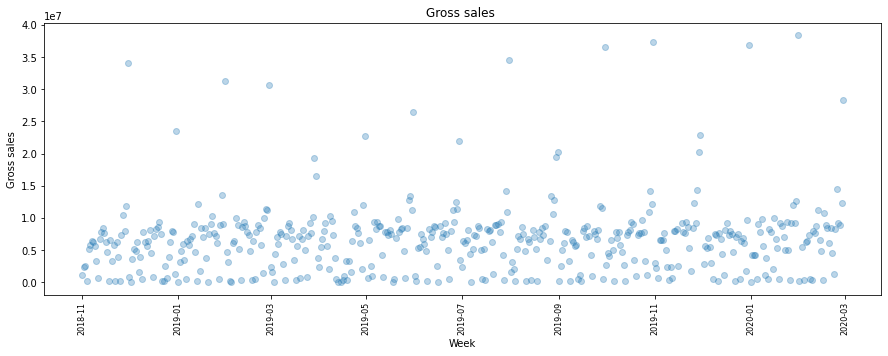

In [14]:
plt.scatter(Sec_inv_grp.just_date , Sec_inv_grp.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("Gross sales")
plt.title("Gross sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

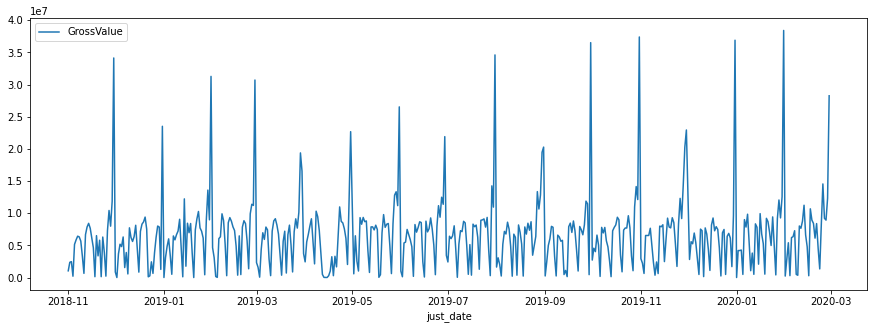

In [15]:
Sec_inv_grp.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

In [16]:
# remove z score > 3 
Sec_invoice_Agg = Sec_inv_grp[(np.abs(stats.zscore(Sec_inv_grp["GrossValue"])) < 3)]

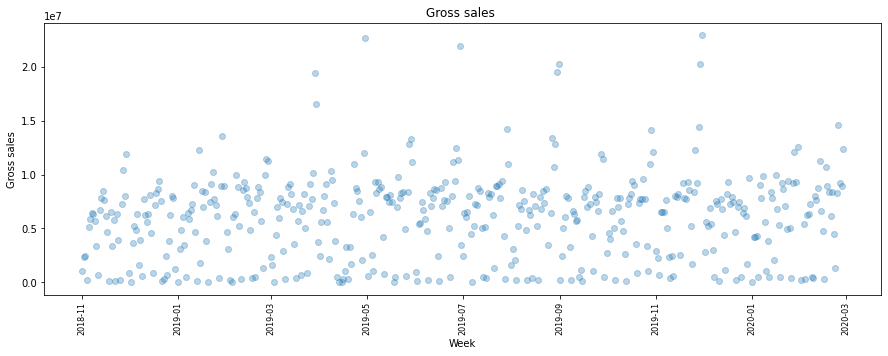

In [17]:
plt.scatter(Sec_invoice_Agg.just_date , Sec_invoice_Agg.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("Gross sales")
plt.title("Gross sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

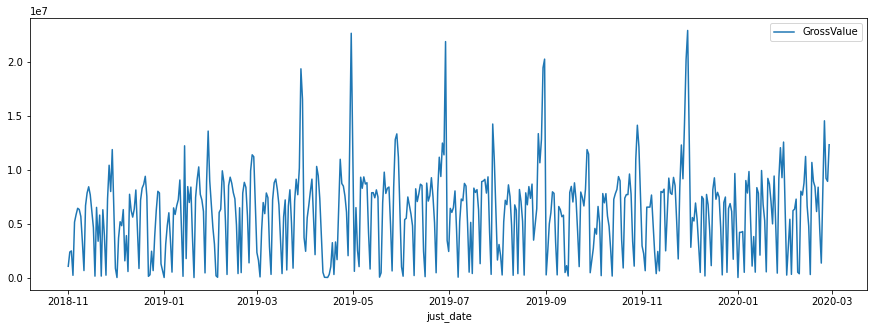

In [18]:
Sec_invoice_Agg.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

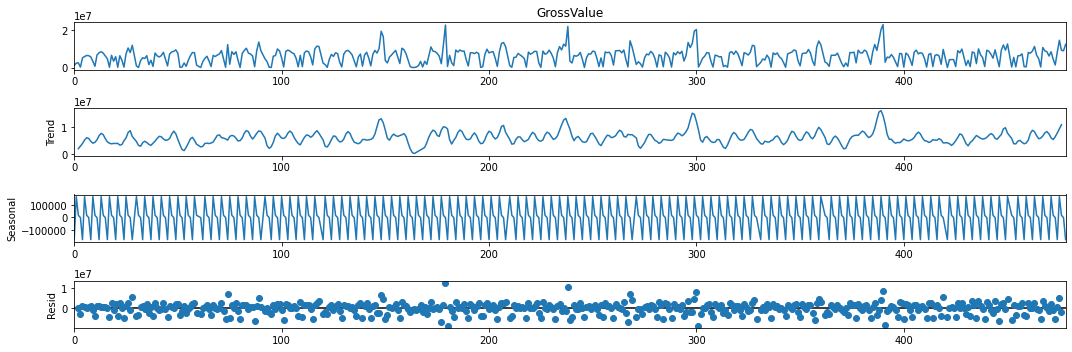

In [19]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =4)
decomposition.plot()
plt.show()

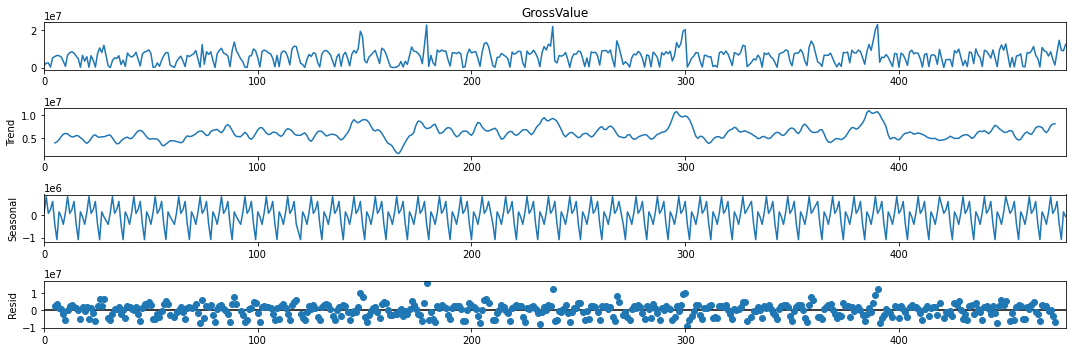

In [20]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =10)
decomposition.plot()
plt.show()

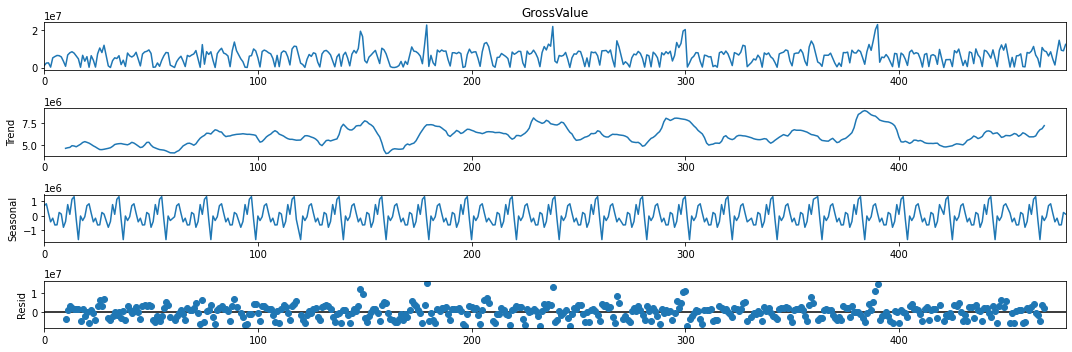

In [21]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =20)
decomposition.plot()
plt.show()

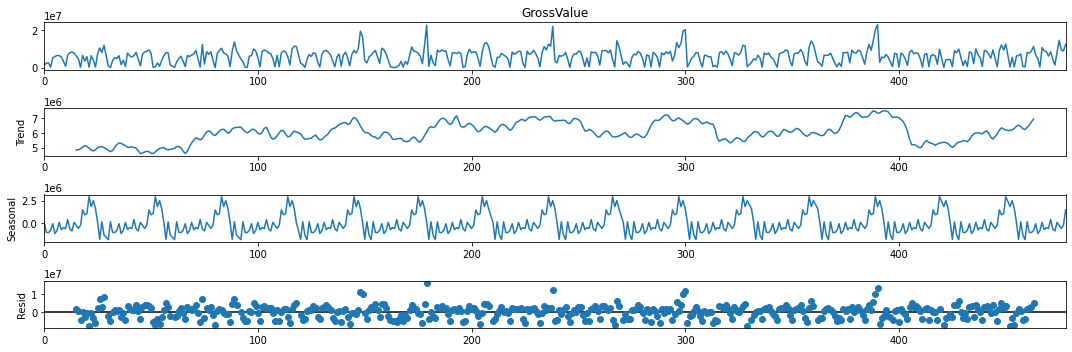

In [22]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =30)
decomposition.plot()
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Sec_invoice_Agg['GrossValue'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -6.446580e+00
p-value                        1.560474e-08
#Lags Used                     1.600000e+01
Number of Observations Used    4.520000e+02
Critical Value (1%)           -3.444900e+00
Critical Value (5%)           -2.867956e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


In [32]:
 #fill in the missing dates
drange = pd.date_range(start=Sec_invoice_Agg.just_date.min(), end=Sec_invoice_Agg.just_date.max())
Sec_invoice_Agg = Sec_invoice_Agg.set_index('just_date').reindex(drange).rename_axis('just_date').reset_index()

In [33]:
#fill missing value with mean
Sec_invoice_Agg.fillna({"GrossValue":Sec_invoice_Agg['GrossValue'].mean().round(1)}, inplace=True)

In [40]:
Sec_inv_grp = Sec_invoice_Agg.sort_index()
Sec_inv_grp.head(50)

,just_date,GrossValue
0,2018-11-01,1053634.82
1,2018-11-02,2381350.80
2,2018-11-03,2481154.42
3,2018-11-04,216434.55
4,2018-11-05,5156889.73
5,2018-11-06,5860145.19
6,2018-11-07,6439714.29
7,2018-11-08,6323552.76
8,2018-11-09,5674556.29
9,2018-11-10,3332265.68


In [41]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Sec_inv_grp.loc[Sec_inv_grp['just_date'] <= "2019-11-30"]
train = train.set_index('just_date')
test = Sec_inv_grp.loc[Sec_inv_grp['just_date'] > "2019-11-30"]
test = test.set_index('just_date')

In [42]:
from pmdarima import auto_arima
model = auto_arima(train.GrossValue, test='adf', trace=True, start_p=1,start_q=1 ,max_p=4,max_q=4 
                   ,suppress_warnings=True,stepwise=False,seasonal=False)
results = model.fit(train.GrossValue)
results.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13602.894, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13391.880, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=13344.264, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=13355.994, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=13338.268, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13159.002, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13134.198, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13066.393, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=13062.588, Time=0.35 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=13066.449, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13155.853, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13066.655, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=13066.222, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=13137.188, Time=0.05 sec
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  395
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -6526.294
Date:                Tue, 19 Apr 2022   AIC                          13062.588
Time:                        20:32:57   BIC                          13082.482
Sample:                             0   HQIC                         13070.470
                                - 395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5305.501      0.000       1.000       1.000
ma.L1         -0.5178      0.040    -12.983      0.000      -0.596      -0.440
ma.L2         -0.3780      0.059     -6.356      0.000      -0.495      -0.261
ma.L3         -0.0885      0.052     -1.700      0.089      -0.191       0.014
sigma2       1.38e+13    6.4e-16   2.16e+28      0.000    1.38e+13    1.38e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                21.32
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.32
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.71e+45. Standard errors may be unstable.
"""

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['GrossValue'],
                order=(1,0,3),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  war

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GrossValue   No. Observations:                  395
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -6526.294
Date:                Tue, 19 Apr 2022   AIC                          13062.588
Time:                        20:33:06   BIC                          13082.482
Sample:                    11-01-2018   HQIC                         13070.470
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5305.501      0.000       1.000       1.000
ma.L1         -0.5178      0.040    -12.983      0.000      -0.596      -0.440
ma.L2         -0.3780      0.059     -6.356      0.000      -0.495      -0.261
ma.L3         -0.0885      0.052     -1.700      0.089      -0.191       0.014
sigma2       1.38e+13    6.4e-16   2.16e+28      0.000    1.38e+13    1.38e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                21.32
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.32
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.71e+45. Standard errors may be unstable.
"""

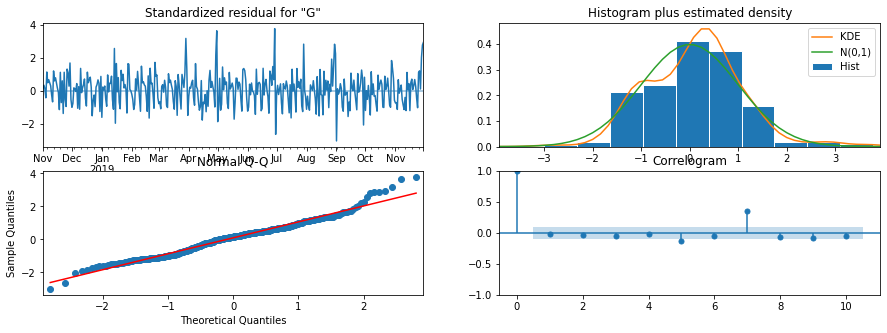

In [44]:
results.plot_diagnostics()
plt.show()

In [47]:
test

,GrossValue
just_date,
2019-12-01,6051799.90
2019-12-02,2817015.12
2019-12-03,5576455.68
2019-12-04,5258268.84
2019-12-05,6926519.10
...,...
2020-02-24,8256394.54
2020-02-25,14559587.84
2020-02-26,9219944.47


In [50]:
test_result

2019-12-01    1.267472e+07
2019-12-02    7.609603e+06
2019-12-03    6.637760e+06
2019-12-04    6.637455e+06
2019-12-05    6.637151e+06
                  ...     
2020-02-24    6.612554e+06
2020-02-25    6.612251e+06
2020-02-26    6.611948e+06
2020-02-27    6.611645e+06
2020-02-28    6.611342e+06
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_result = results.predict(start='2019-12-01', end='2020-02-28')
mse = mean_squared_error(test, test_result)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 3568760.176446


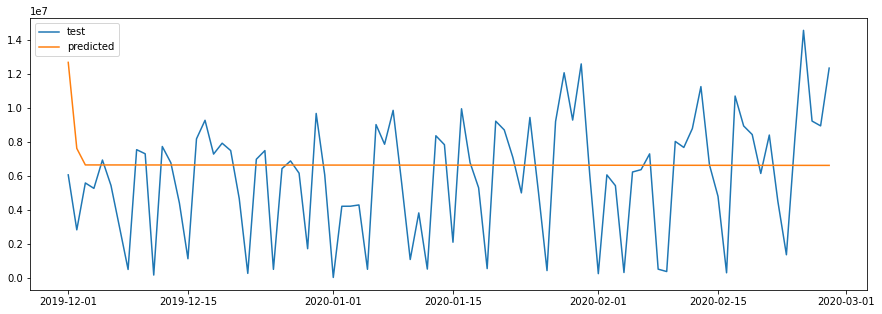

In [51]:
plt.plot(test)
plt.plot(test_result)
plt.legend(['test', 'predicted'])